In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "100X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 1


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_100X-BREAKHIS-Dataset-60-10-30-VGGINet/1'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/100X/1'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1128 files belonging to 2 classes.


Found 187 files belonging to 2 classes.


Found 566 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3836 - accuracy: 0.4453

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 5.7000 - accuracy: 0.5742

3/9 [=========>....................] - ETA: 4s - loss: 5.6634 - accuracy: 0.6380

4/9 [============>.................] - ETA: 6s - loss: 5.5251 - accuracy: 0.6523

5/9 [===============>..............] - ETA: 5s - loss: 5.3534 - accuracy: 0.6781

6/9 [===================>..........] - ETA: 3s - loss: 5.0715 - accuracy: 0.6927

7/9 [======================>.......] - ETA: 2s - loss: 4.7348 - accuracy: 0.7154

8/9 [=========================>....] - ETA: 1s - loss: 4.3904 - accuracy: 0.7305

9/9 [==============================] - ETA: 0s - loss: 4.1738 - accuracy: 0.7411

9/9 [==============================] - 35s 4s/step - loss: 4.1738 - accuracy: 0.7411 - val_loss: 51.2087 - val_accuracy: 0.4064


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 4.2327 - accuracy: 0.7500

2/9 [=====>........................] - ETA: 14s - loss: 3.1452 - accuracy: 0.8008

3/9 [=========>....................] - ETA: 10s - loss: 2.8725 - accuracy: 0.8073

4/9 [============>.................] - ETA: 10s - loss: 2.6500 - accuracy: 0.8125

5/9 [===============>..............] - ETA: 7s - loss: 2.5940 - accuracy: 0.8172 

6/9 [===================>..........] - ETA: 5s - loss: 2.5502 - accuracy: 0.8203

7/9 [======================>.......] - ETA: 3s - loss: 2.4698 - accuracy: 0.8225

8/9 [=========================>....] - ETA: 1s - loss: 2.3360 - accuracy: 0.8271

9/9 [==============================] - ETA: 0s - loss: 2.2215 - accuracy: 0.8333

9/9 [==============================] - 16s 2s/step - loss: 2.2215 - accuracy: 0.8333 - val_loss: 5.8870 - val_accuracy: 0.8610


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8708 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 14s - loss: 1.9997 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 10s - loss: 1.6480 - accuracy: 0.8906

4/9 [============>.................] - ETA: 10s - loss: 1.6997 - accuracy: 0.8945

5/9 [===============>..............] - ETA: 7s - loss: 1.5262 - accuracy: 0.9000 

6/9 [===================>..........] - ETA: 5s - loss: 1.5087 - accuracy: 0.8971

7/9 [======================>.......] - ETA: 3s - loss: 1.4746 - accuracy: 0.8973

8/9 [=========================>....] - ETA: 1s - loss: 1.4129 - accuracy: 0.8965

9/9 [==============================] - ETA: 0s - loss: 1.3474 - accuracy: 0.8954

9/9 [==============================] - 16s 2s/step - loss: 1.3474 - accuracy: 0.8954 - val_loss: 1.4133 - val_accuracy: 0.9305


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4785 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 5s - loss: 1.3375 - accuracy: 0.8789

3/9 [=========>....................] - ETA: 11s - loss: 1.1867 - accuracy: 0.8880

4/9 [============>.................] - ETA: 11s - loss: 1.0937 - accuracy: 0.8887

5/9 [===============>..............] - ETA: 7s - loss: 1.0661 - accuracy: 0.8906 

6/9 [===================>..........] - ETA: 5s - loss: 1.1829 - accuracy: 0.8906

7/9 [======================>.......] - ETA: 3s - loss: 1.2371 - accuracy: 0.8906

8/9 [=========================>....] - ETA: 1s - loss: 1.1729 - accuracy: 0.8916

9/9 [==============================] - ETA: 0s - loss: 1.1668 - accuracy: 0.8910

9/9 [==============================] - 17s 2s/step - loss: 1.1668 - accuracy: 0.8910 - val_loss: 2.4818 - val_accuracy: 0.8877


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8619 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 14s - loss: 0.9822 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 10s - loss: 1.1487 - accuracy: 0.8854

4/9 [============>.................] - ETA: 10s - loss: 1.0539 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 0.9522 - accuracy: 0.8922 

6/9 [===================>..........] - ETA: 5s - loss: 0.9069 - accuracy: 0.9023

7/9 [======================>.......] - ETA: 3s - loss: 1.0078 - accuracy: 0.8996

8/9 [=========================>....] - ETA: 1s - loss: 1.0263 - accuracy: 0.8984

9/9 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.9007

9/9 [==============================] - 16s 2s/step - loss: 0.9870 - accuracy: 0.9007 - val_loss: 1.4948 - val_accuracy: 0.8824


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6138 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.8447 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 9s - loss: 0.8002 - accuracy: 0.9115 

4/9 [============>.................] - ETA: 9s - loss: 0.9484 - accuracy: 0.8984

5/9 [===============>..............] - ETA: 7s - loss: 1.0345 - accuracy: 0.8969

6/9 [===================>..........] - ETA: 5s - loss: 0.9772 - accuracy: 0.9049

7/9 [======================>.......] - ETA: 3s - loss: 0.9374 - accuracy: 0.9051

8/9 [=========================>....] - ETA: 1s - loss: 0.9249 - accuracy: 0.9043

9/9 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.9043

9/9 [==============================] - 16s 2s/step - loss: 0.9070 - accuracy: 0.9043 - val_loss: 1.5274 - val_accuracy: 0.9198


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2075 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 14s - loss: 1.3011 - accuracy: 0.8672

3/9 [=========>....................] - ETA: 10s - loss: 1.0148 - accuracy: 0.8854

4/9 [============>.................] - ETA: 10s - loss: 0.9305 - accuracy: 0.8945

5/9 [===============>..............] - ETA: 7s - loss: 0.9123 - accuracy: 0.9062 

6/9 [===================>..........] - ETA: 5s - loss: 0.8310 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 0.8102 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 0.8221 - accuracy: 0.9160

9/9 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.9096

9/9 [==============================] - 17s 2s/step - loss: 1.0283 - accuracy: 0.9096 - val_loss: 1.0912 - val_accuracy: 0.9305


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8709 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 11s - loss: 0.7448 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 8s - loss: 0.9375 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 1.0710 - accuracy: 0.9121

5/9 [===============>..............] - ETA: 7s - loss: 0.9472 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 4s - loss: 1.0585 - accuracy: 0.9193

7/9 [======================>.......] - ETA: 3s - loss: 1.0847 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 1.2026 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.9060

9/9 [==============================] - 16s 2s/step - loss: 1.2331 - accuracy: 0.9060 - val_loss: 1.1804 - val_accuracy: 0.9305


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9523 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 14s - loss: 1.1610 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 9s - loss: 1.1739 - accuracy: 0.8724 

4/9 [============>.................] - ETA: 10s - loss: 1.1424 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 1.1239 - accuracy: 0.8875 

6/9 [===================>..........] - ETA: 5s - loss: 1.0884 - accuracy: 0.8893

7/9 [======================>.......] - ETA: 3s - loss: 0.9813 - accuracy: 0.8984

8/9 [=========================>....] - ETA: 1s - loss: 1.0210 - accuracy: 0.8945

9/9 [==============================] - ETA: 0s - loss: 1.0399 - accuracy: 0.8954

9/9 [==============================] - 16s 2s/step - loss: 1.0399 - accuracy: 0.8954 - val_loss: 1.5595 - val_accuracy: 0.9198


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7839 - accuracy: 0.8594

2/9 [=====>........................] - ETA: 14s - loss: 2.0547 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 10s - loss: 1.5965 - accuracy: 0.8932

4/9 [============>.................] - ETA: 9s - loss: 1.3837 - accuracy: 0.8984 

5/9 [===============>..............] - ETA: 7s - loss: 1.2178 - accuracy: 0.9094

6/9 [===================>..........] - ETA: 5s - loss: 1.2256 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 1.1196 - accuracy: 0.9074

8/9 [=========================>....] - ETA: 1s - loss: 1.0785 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 1.1488 - accuracy: 0.9060

9/9 [==============================] - 17s 2s/step - loss: 1.1488 - accuracy: 0.9060 - val_loss: 1.1471 - val_accuracy: 0.9305


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3016 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 10s - loss: 0.4169 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 0.5036 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 9s - loss: 0.5282 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 6s - loss: 0.6060 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 4s - loss: 0.8854 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 2s - loss: 0.9000 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 0.9027 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.9273

9/9 [==============================] - 15s 2s/step - loss: 0.9012 - accuracy: 0.9273 - val_loss: 1.0247 - val_accuracy: 0.9465


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5034 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.8096 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 16s - loss: 0.8975 - accuracy: 0.9062

4/9 [============>.................] - ETA: 11s - loss: 0.8700 - accuracy: 0.9082

5/9 [===============>..............] - ETA: 8s - loss: 0.9520 - accuracy: 0.9125 

6/9 [===================>..........] - ETA: 5s - loss: 1.0377 - accuracy: 0.9036

7/9 [======================>.......] - ETA: 3s - loss: 1.0813 - accuracy: 0.9029

8/9 [=========================>....] - ETA: 1s - loss: 0.9795 - accuracy: 0.9131

9/9 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.9140

9/9 [==============================] - 17s 2s/step - loss: 0.9923 - accuracy: 0.9140 - val_loss: 1.4565 - val_accuracy: 0.9091


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9479 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 1.0871 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 1.4683 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 10s - loss: 1.3539 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 1.1686 - accuracy: 0.9312 

6/9 [===================>..........] - ETA: 5s - loss: 1.1007 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 1.0823 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 1.0769 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.9264

9/9 [==============================] - 16s 2s/step - loss: 1.0642 - accuracy: 0.9264 - val_loss: 1.0462 - val_accuracy: 0.9519


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3767 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.5729 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 8s - loss: 0.5024 - accuracy: 0.9323

4/9 [============>.................] - ETA: 10s - loss: 0.6130 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7257 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 3s - loss: 0.8215 - accuracy: 0.9263

8/9 [=========================>....] - ETA: 1s - loss: 0.8024 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.9291

9/9 [==============================] - 16s 2s/step - loss: 0.7877 - accuracy: 0.9291 - val_loss: 0.8452 - val_accuracy: 0.9519


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8034 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.7912 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 10s - loss: 0.7672 - accuracy: 0.9271

4/9 [============>.................] - ETA: 9s - loss: 1.0101 - accuracy: 0.9160 

5/9 [===============>..............] - ETA: 7s - loss: 0.9663 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 5s - loss: 0.9665 - accuracy: 0.9193

7/9 [======================>.......] - ETA: 3s - loss: 0.8576 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.7902 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.9036 - accuracy: 0.9238

9/9 [==============================] - 16s 2s/step - loss: 0.9036 - accuracy: 0.9238 - val_loss: 0.4814 - val_accuracy: 0.9465


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8372 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.5748 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.7883 - accuracy: 0.9349

4/9 [============>.................] - ETA: 10s - loss: 1.1130 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 1.0728 - accuracy: 0.9281 

6/9 [===================>..........] - ETA: 5s - loss: 1.0346 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 1.0312 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.9945 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.9264

9/9 [==============================] - 17s 2s/step - loss: 0.9274 - accuracy: 0.9264 - val_loss: 1.5679 - val_accuracy: 0.9358


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0589 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.7069 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 9s - loss: 0.8632 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.8245 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 5s - loss: 0.7179 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.7613 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.7153 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.9441

9/9 [==============================] - 17s 2s/step - loss: 0.6932 - accuracy: 0.9441 - val_loss: 1.1074 - val_accuracy: 0.9465


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3635 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.7211 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7643 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 10s - loss: 0.9660 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 1.0387 - accuracy: 0.9172 

6/9 [===================>..........] - ETA: 5s - loss: 0.9758 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 0.8608 - accuracy: 0.9252

8/9 [=========================>....] - ETA: 1s - loss: 0.8937 - accuracy: 0.9238

9/9 [==============================] - ETA: 0s - loss: 0.8587 - accuracy: 0.9238

9/9 [==============================] - 17s 2s/step - loss: 0.8587 - accuracy: 0.9238 - val_loss: 0.9818 - val_accuracy: 0.9626


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7893 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 10s - loss: 1.3251 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 8s - loss: 1.0642 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 6s - loss: 1.0804 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 1.0664 - accuracy: 0.9281

6/9 [===================>..........] - ETA: 5s - loss: 1.1795 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 1.0610 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.9513 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.9379

9/9 [==============================] - 16s 2s/step - loss: 0.9158 - accuracy: 0.9379 - val_loss: 0.8600 - val_accuracy: 0.9412


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8593 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.7155 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 10s - loss: 0.6341 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.6536 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6538 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.6996 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.7957 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.9326

9/9 [==============================] - 17s 2s/step - loss: 0.7583 - accuracy: 0.9326 - val_loss: 0.4483 - val_accuracy: 0.9733


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6637 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7566 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7143 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.5417 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5263 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.5358 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5568 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5204 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.9521

9/9 [==============================] - 17s 2s/step - loss: 0.5349 - accuracy: 0.9521 - val_loss: 1.1419 - val_accuracy: 0.9251


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.2710 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 7s - loss: 0.4427 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.4589 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4333 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.5543 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5008 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5307 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.9566

9/9 [==============================] - 16s 2s/step - loss: 0.5047 - accuracy: 0.9566 - val_loss: 1.0885 - val_accuracy: 0.9465


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8955 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 0.9507 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 10s - loss: 1.0826 - accuracy: 0.9062

4/9 [============>.................] - ETA: 7s - loss: 0.8653 - accuracy: 0.9219 

5/9 [===============>..............] - ETA: 7s - loss: 0.7740 - accuracy: 0.9234

6/9 [===================>..........] - ETA: 5s - loss: 0.8734 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.8285 - accuracy: 0.9275

8/9 [=========================>....] - ETA: 1s - loss: 0.8410 - accuracy: 0.9316

9/9 [==============================] - ETA: 0s - loss: 0.7988 - accuracy: 0.9317

9/9 [==============================] - 17s 2s/step - loss: 0.7988 - accuracy: 0.9317 - val_loss: 0.9587 - val_accuracy: 0.9305


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7782 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.9463 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 8s - loss: 1.1374 - accuracy: 0.9115

4/9 [============>.................] - ETA: 10s - loss: 0.9460 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.8990 - accuracy: 0.9344 

6/9 [===================>..........] - ETA: 5s - loss: 0.8799 - accuracy: 0.9388

7/9 [======================>.......] - ETA: 3s - loss: 0.8917 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.8661 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.9397

9/9 [==============================] - 16s 2s/step - loss: 0.8707 - accuracy: 0.9397 - val_loss: 0.8319 - val_accuracy: 0.9626


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9850 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.8535 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.8216 - accuracy: 0.9323

4/9 [============>.................] - ETA: 10s - loss: 0.7320 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 5s - loss: 0.7282 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.6532 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.7059 - accuracy: 0.9434

9/9 [==============================] - ETA: 0s - loss: 0.7248 - accuracy: 0.9415

9/9 [==============================] - 16s 2s/step - loss: 0.7248 - accuracy: 0.9415 - val_loss: 1.3075 - val_accuracy: 0.9412


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6639 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 16s - loss: 1.1093 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 11s - loss: 1.0066 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.9087 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.9865 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.8967 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.9169 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.8823 - accuracy: 0.9482

9/9 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.9504

9/9 [==============================] - 17s 2s/step - loss: 0.8144 - accuracy: 0.9504 - val_loss: 0.5439 - val_accuracy: 0.9519


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1750 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2964 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3636 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.4576 - accuracy: 0.9570 

5/9 [===============>..............] - ETA: 7s - loss: 0.6827 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.6125 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5333 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.5038 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.9512

9/9 [==============================] - 16s 2s/step - loss: 0.6079 - accuracy: 0.9512 - val_loss: 0.4648 - val_accuracy: 0.9519


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6525 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 11s - loss: 0.4080 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 8s - loss: 0.4920 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.4955 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.4975 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 4s - loss: 0.5920 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 2s - loss: 0.5862 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5997 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.9521

9/9 [==============================] - 16s 2s/step - loss: 0.6117 - accuracy: 0.9521 - val_loss: 1.0494 - val_accuracy: 0.9465


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6506 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4213 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.7170 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 11s - loss: 0.8064 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 8s - loss: 0.6919 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.8305 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.9026 - accuracy: 0.9404

9/9 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.9406

9/9 [==============================] - 17s 2s/step - loss: 0.8605 - accuracy: 0.9406 - val_loss: 0.9206 - val_accuracy: 0.9519


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7960 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.7604 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6530 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.5997 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6119 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.5994 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5565 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5489 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.9530

9/9 [==============================] - 16s 2s/step - loss: 0.5152 - accuracy: 0.9530 - val_loss: 0.3467 - val_accuracy: 0.9733


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3326 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2973 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3492 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.3892 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.3527 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.3577 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.3517 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.3229 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.9654

9/9 [==============================] - 17s 2s/step - loss: 0.3193 - accuracy: 0.9654 - val_loss: 0.5714 - val_accuracy: 0.9733


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6691 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.5575 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.5622 - accuracy: 0.9505

4/9 [============>.................] - ETA: 10s - loss: 0.7277 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.6813 - accuracy: 0.9500 

6/9 [===================>..........] - ETA: 5s - loss: 0.6167 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.6094 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.9521

9/9 [==============================] - 16s 2s/step - loss: 0.6118 - accuracy: 0.9521 - val_loss: 0.9546 - val_accuracy: 0.9519


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8575 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.7967 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.5934 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.5272 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6197 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.6150 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.6249 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.6168 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.9486

9/9 [==============================] - 17s 2s/step - loss: 0.5995 - accuracy: 0.9486 - val_loss: 0.3613 - val_accuracy: 0.9679


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7598 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.8125 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.7299 - accuracy: 0.9479

4/9 [============>.................] - ETA: 11s - loss: 0.9961 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 1.0840 - accuracy: 0.9359 

6/9 [===================>..........] - ETA: 5s - loss: 0.9393 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.9174 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.8231 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.8102 - accuracy: 0.9468

9/9 [==============================] - 17s 2s/step - loss: 0.8102 - accuracy: 0.9468 - val_loss: 0.4852 - val_accuracy: 0.9679


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8281 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.6833 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.6532 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.5524 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5902 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.5860 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5821 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5401 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.9539

9/9 [==============================] - 16s 2s/step - loss: 0.5677 - accuracy: 0.9539 - val_loss: 0.5003 - val_accuracy: 0.9679


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7090 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.7442 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6184 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.6747 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.6001 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.6170 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.6594 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.6153 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.9574

9/9 [==============================] - 16s 2s/step - loss: 0.6269 - accuracy: 0.9574 - val_loss: 0.4329 - val_accuracy: 0.9679


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4553 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5678 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5426 - accuracy: 0.9609

4/9 [============>.................] - ETA: 11s - loss: 0.5327 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.6699 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.6328 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5498 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.5581 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.9548

9/9 [==============================] - 17s 2s/step - loss: 0.6065 - accuracy: 0.9548 - val_loss: 0.6910 - val_accuracy: 0.9626


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2255 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.7438 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.5329 - accuracy: 0.9661

4/9 [============>.................] - ETA: 6s - loss: 0.5673 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 4s - loss: 0.5144 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 3s - loss: 0.5008 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 2s - loss: 0.4643 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5121 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.9601

9/9 [==============================] - 13s 1s/step - loss: 0.4724 - accuracy: 0.9601 - val_loss: 0.3687 - val_accuracy: 0.9733


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3362 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.4184 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.5912 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.5270 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.4227 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.3757 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4055 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4017 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.4153 - accuracy: 0.9628 - val_loss: 0.3582 - val_accuracy: 0.9733


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2847 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.3669 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3053 - accuracy: 0.9661

4/9 [============>.................] - ETA: 7s - loss: 0.4813 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 5s - loss: 0.4152 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 3s - loss: 0.4262 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 2s - loss: 0.4428 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4830 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.9637

9/9 [==============================] - 14s 2s/step - loss: 0.5083 - accuracy: 0.9637 - val_loss: 0.3503 - val_accuracy: 0.9733


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2523 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4293 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.3243 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3201 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3762 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3915 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3556 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4831 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.4582 - accuracy: 0.9672 - val_loss: 0.3150 - val_accuracy: 0.9786


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3722 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3821 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4757 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.5141 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4729 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.5314 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.6288 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5882 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.5339 - accuracy: 0.9645 - val_loss: 0.4054 - val_accuracy: 0.9733


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2707 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 16s - loss: 0.6102 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 13s - loss: 0.5888 - accuracy: 0.9557

4/9 [============>.................] - ETA: 11s - loss: 0.5585 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 8s - loss: 0.5279 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.5253 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.6254 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.6308 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.9539

9/9 [==============================] - 18s 2s/step - loss: 0.5962 - accuracy: 0.9539 - val_loss: 0.2441 - val_accuracy: 0.9786


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5482 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3682 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3710 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2986 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3665 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.3865 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.3904 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.3662 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.3926 - accuracy: 0.9672 - val_loss: 0.1583 - val_accuracy: 0.9893


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2578 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.1790 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3349 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.2870 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.2375 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.2046 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.1987 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.1812 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2225 - accuracy: 0.9778 - val_loss: 0.3725 - val_accuracy: 0.9786


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9577 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.6139 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.7533 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.6075 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5905 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.5301 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5115 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.5324 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.9637

9/9 [==============================] - 17s 2s/step - loss: 0.5353 - accuracy: 0.9637 - val_loss: 0.3053 - val_accuracy: 0.9840


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4900 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3263 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2503 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.1912 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2297 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.1966 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.1926 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2377 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9716

9/9 [==============================] - 17s 2s/step - loss: 0.3002 - accuracy: 0.9716 - val_loss: 0.2182 - val_accuracy: 0.9840


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2119 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4350 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3645 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3102 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.2619 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3210 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3596 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3276 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.3675 - accuracy: 0.9707 - val_loss: 0.4718 - val_accuracy: 0.9733


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7463 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.9341 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.7889 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5872 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.5346 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.5618 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5140 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.9699

9/9 [==============================] - 17s 2s/step - loss: 0.4798 - accuracy: 0.9699 - val_loss: 0.5497 - val_accuracy: 0.9733


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5530 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.3292 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4475 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.4356 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.5092 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.4920 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.5379 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5371 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.4876 - accuracy: 0.9699 - val_loss: 0.4525 - val_accuracy: 0.9733


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4076 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.4192 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.4729 - accuracy: 0.9453

4/9 [============>.................] - ETA: 6s - loss: 0.4926 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 6s - loss: 0.4207 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.4198 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.3768 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4349 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.9637

9/9 [==============================] - 16s 2s/step - loss: 0.4255 - accuracy: 0.9637 - val_loss: 0.6178 - val_accuracy: 0.9733


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1397 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2317 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1974 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3723 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3452 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4190 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3672 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3421 - accuracy: 0.9770 - val_loss: 0.2777 - val_accuracy: 0.9840


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3857 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2879 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2539 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.2057 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.2020 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.1836 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2330 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2826 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.2940 - accuracy: 0.9707 - val_loss: 0.2563 - val_accuracy: 0.9840


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5267 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.3674 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3689 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.2981 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2794 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2423 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2266 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2215 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2194 - accuracy: 0.9778 - val_loss: 0.4731 - val_accuracy: 0.9626


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6683 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4583 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3594 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 7s - loss: 0.4148 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3776 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3147 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3524 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3372 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.9743

9/9 [==============================] - 17s 2s/step - loss: 0.4024 - accuracy: 0.9743 - val_loss: 0.2580 - val_accuracy: 0.9840


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4813 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 11s - loss: 0.3106 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.4885 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4886 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 6s - loss: 0.4890 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4845 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 2s - loss: 0.4154 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3705 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3483 - accuracy: 0.9752 - val_loss: 0.7308 - val_accuracy: 0.9572


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2033 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.2093 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 16s - loss: 0.2605 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.3357 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 8s - loss: 0.3157 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3339 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4264 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4200 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.9672

9/9 [==============================] - 17s 2s/step - loss: 0.4114 - accuracy: 0.9672 - val_loss: 0.7527 - val_accuracy: 0.9679


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1855 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.0879 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1972 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.1593 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.1647 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.1932 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.1949 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.1888 - accuracy: 0.9787 - val_loss: 0.6111 - val_accuracy: 0.9733


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5531 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5622 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 14s - loss: 0.3860 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.4932 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 8s - loss: 0.5212 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 6s - loss: 0.4783 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4816 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4729 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.9716

9/9 [==============================] - 19s 2s/step - loss: 0.4591 - accuracy: 0.9716 - val_loss: 0.3422 - val_accuracy: 0.9840


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2853 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1453 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2874 - accuracy: 0.9870

4/9 [============>.................] - ETA: 7s - loss: 0.2705 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.3095 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.3968 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4572 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4936 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.9690

9/9 [==============================] - 17s 2s/step - loss: 0.4833 - accuracy: 0.9690 - val_loss: 0.4867 - val_accuracy: 0.9679


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0616 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2211 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2325 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.2855 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2710 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.2681 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3581 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4111 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.9707

9/9 [==============================] - 17s 2s/step - loss: 0.4274 - accuracy: 0.9707 - val_loss: 0.3561 - val_accuracy: 0.9733


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0955 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0794 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1114 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2557 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3367 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3923 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3749 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3840 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.4080 - accuracy: 0.9734 - val_loss: 2.5738 - val_accuracy: 0.9144


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2334 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1369 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1375 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1645 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2388 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2509 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.2605 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.2534 - accuracy: 0.9725 - val_loss: 0.9297 - val_accuracy: 0.9519


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6774 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4450 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3280 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2771 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2860 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2875 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3076 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3602 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.3284 - accuracy: 0.9787 - val_loss: 0.7173 - val_accuracy: 0.9626


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1040 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2220 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2943 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3022 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3460 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4120 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.3889 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.3661 - accuracy: 0.9690 - val_loss: 0.1164 - val_accuracy: 0.9893


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2723 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2166 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2065 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2194 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3462 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3974 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3500 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4616 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.5424 - accuracy: 0.9672 - val_loss: 0.3136 - val_accuracy: 0.9840


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8713 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.5210 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4934 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.4871 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.5122 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4413 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4350 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3954 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.9681

9/9 [==============================] - 16s 2s/step - loss: 0.4108 - accuracy: 0.9681 - val_loss: 0.8601 - val_accuracy: 0.9679


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1787 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.1038 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.1781 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.1385 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.1918 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.1706 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 2s - loss: 0.1801 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2196 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.3955 - accuracy: 0.9707 - val_loss: 0.5547 - val_accuracy: 0.9679


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0941 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.0742 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.4544 - accuracy: 0.9714

4/9 [============>.................] - ETA: 6s - loss: 0.4507 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 6s - loss: 0.4038 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.4436 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3845 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3647 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3398 - accuracy: 0.9796 - val_loss: 1.2340 - val_accuracy: 0.9251


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3468 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 15s - loss: 0.2917 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3864 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.4477 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3703 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3660 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3486 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4066 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.9690

9/9 [==============================] - 17s 2s/step - loss: 0.3873 - accuracy: 0.9690 - val_loss: 0.2155 - val_accuracy: 0.9733


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0411 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.7653 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5102 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4741 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4120 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3916 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3689 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4045 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3794 - accuracy: 0.9761 - val_loss: 0.3951 - val_accuracy: 0.9786


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6041 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3567 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.4205 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.3431 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3602 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3408 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3231 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3105 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9699

9/9 [==============================] - 17s 2s/step - loss: 0.3479 - accuracy: 0.9699 - val_loss: 0.1437 - val_accuracy: 0.9733


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2464 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.2583 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1813 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.1960 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2282 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.1917 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.1643 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1511 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.1660 - accuracy: 0.9840 - val_loss: 0.1189 - val_accuracy: 0.9893


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7700 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5614 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5106 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3830 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3619 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3371 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3519 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3119 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2989 - accuracy: 0.9778 - val_loss: 0.1438 - val_accuracy: 0.9947


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0960 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1094 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1006 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1780 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1506 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1816 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2239 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2332 - accuracy: 0.9849 - val_loss: 0.7193 - val_accuracy: 0.9572


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1243 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2728 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4580 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3780 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4855 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4100 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4586 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.5188 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.9734

9/9 [==============================] - 17s 2s/step - loss: 0.4713 - accuracy: 0.9734 - val_loss: 0.7102 - val_accuracy: 0.9519


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0588 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1834 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2908 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3785 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3649 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3486 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3286 - accuracy: 0.9805 - val_loss: 0.2011 - val_accuracy: 0.9786


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3244 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2469 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3175 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.2597 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2985 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.2859 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2853 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3208 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.3228 - accuracy: 0.9699 - val_loss: 0.3500 - val_accuracy: 0.9840


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0984 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1613 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1939 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1640 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.1774 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2220 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2024 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2148 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9814

9/9 [==============================] - 17s 2s/step - loss: 0.2133 - accuracy: 0.9814 - val_loss: 0.0894 - val_accuracy: 0.9893


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1108 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0929 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0635 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0674 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0539 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0655 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.0711 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.0716 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9885

9/9 [==============================] - 16s 2s/step - loss: 0.0962 - accuracy: 0.9885 - val_loss: 0.2014 - val_accuracy: 0.9893


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2894 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.3563 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2500 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2134 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2254 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2056 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2346 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2717 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.2507 - accuracy: 0.9796 - val_loss: 0.0167 - val_accuracy: 0.9947


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0684 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.8293 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.6091 - accuracy: 0.9688

4/9 [============>.................] - ETA: 6s - loss: 0.5463 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4370 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.5849 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.5044 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4732 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.4299 - accuracy: 0.9814 - val_loss: 0.0544 - val_accuracy: 0.9893


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1950 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1717 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1145 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1019 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.0963 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1000 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1248 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2001 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.2035 - accuracy: 0.9832 - val_loss: 0.2937 - val_accuracy: 0.9679


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1906 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3757 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.5215 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.4584 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3767 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3379 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2901 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2627 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.2399 - accuracy: 0.9840 - val_loss: 0.1968 - val_accuracy: 0.9840


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1624 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1458 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.1893 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2011 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2490 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2494 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2732 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.2480 - accuracy: 0.9787 - val_loss: 0.0873 - val_accuracy: 0.9947


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1078 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1974 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2487 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.3319 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 6s - loss: 0.2808 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.3430 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 2s - loss: 0.3565 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4000 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.3814 - accuracy: 0.9787 - val_loss: 0.6672 - val_accuracy: 0.9519


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.2331 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1946 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2882 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.3752 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3555 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3048 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2818 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.9832

9/9 [==============================] - 17s 2s/step - loss: 0.3034 - accuracy: 0.9832 - val_loss: 0.3233 - val_accuracy: 0.9786


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6651 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.6934 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4623 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3867 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3255 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3004 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3010 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2835 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.9823

9/9 [==============================] - 17s 2s/step - loss: 0.2838 - accuracy: 0.9823 - val_loss: 0.3538 - val_accuracy: 0.9786


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4568 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.4356 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.3226 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.3304 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 6s - loss: 0.3182 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2691 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 2s - loss: 0.3019 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2763 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.2814 - accuracy: 0.9832 - val_loss: 0.5083 - val_accuracy: 0.9893


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8505 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5688 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4791 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4325 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3521 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3141 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3105 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2863 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.3444 - accuracy: 0.9787 - val_loss: 0.5370 - val_accuracy: 0.9840


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3504 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4574 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3149 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2873 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3280 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2733 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2692 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2468 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9823

9/9 [==============================] - 17s 2s/step - loss: 0.2248 - accuracy: 0.9823 - val_loss: 1.6287 - val_accuracy: 0.9412


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5120e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0161 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.1281 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 10s - loss: 0.1473 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2219 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2528 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2222 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2160 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2125 - accuracy: 0.9849 - val_loss: 1.1810 - val_accuracy: 0.9733


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2058 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1356 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.3088 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.3080 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2734 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2576 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2573 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9832

9/9 [==============================] - 17s 2s/step - loss: 0.2367 - accuracy: 0.9832 - val_loss: 1.0161 - val_accuracy: 0.9786


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5635 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.5248 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3498 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2624 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 6s - loss: 0.2498 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2439 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2387 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2091 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9885

9/9 [==============================] - 16s 2s/step - loss: 0.1899 - accuracy: 0.9885 - val_loss: 1.0293 - val_accuracy: 0.9786


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6455 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4687 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3124 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2379 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.1903 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1592 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.2377 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2103 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9867

9/9 [==============================] - 17s 2s/step - loss: 0.2249 - accuracy: 0.9867 - val_loss: 1.2684 - val_accuracy: 0.9733


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1338 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0811 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1035 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.0851 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1750 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1459 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2663 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2590 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9814

9/9 [==============================] - 17s 2s/step - loss: 0.2562 - accuracy: 0.9814 - val_loss: 0.5688 - val_accuracy: 0.9733


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1986 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2664 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2714 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2172 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2254 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1932 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1808 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2449 - accuracy: 0.9849 - val_loss: 0.1545 - val_accuracy: 0.9840


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1172 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4125 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2824 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2478 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2595 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2871 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2645 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2737 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2646 - accuracy: 0.9796 - val_loss: 0.8534 - val_accuracy: 0.9626


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1647 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4177 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4151 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3321 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2889 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2624 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2724 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2899 - accuracy: 0.9814 - val_loss: 0.6060 - val_accuracy: 0.9626


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0328 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.3566 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3061 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.2873 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.3037 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.2578 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2210 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2335 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9858

9/9 [==============================] - 16s 2s/step - loss: 0.2133 - accuracy: 0.9858 - val_loss: 0.3463 - val_accuracy: 0.9733


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.2170 - accuracy: 0.9609

2/5 [===========>..................] - ETA: 12s - loss: 1.5134 - accuracy: 0.9492

3/5 [=================>............] - ETA: 9s - loss: 1.0887 - accuracy: 0.9583 

4/5 [=======================>......] - ETA: 5s - loss: 0.9775 - accuracy: 0.9668

5/5 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.9682

5/5 [==============================] - 29s 6s/step - loss: 0.9168 - accuracy: 0.9682


[0.9167553782463074, 0.9681978821754456]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

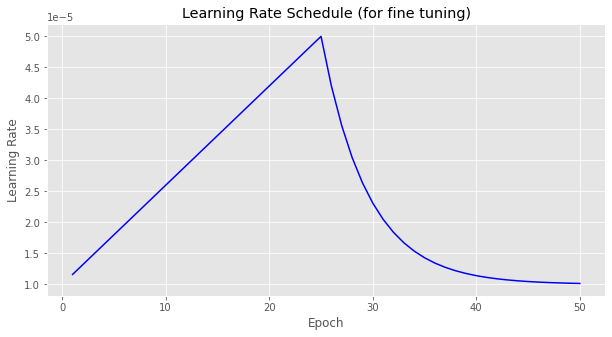

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1128 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0167 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 5s - loss: 0.0111 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 8s - loss: 0.0083 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 11s - loss: 0.0570 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 10s - loss: 0.1336 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 10s - loss: 0.1263 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 11s - loss: 0.1182 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 10s - loss: 0.1061 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 8s - loss: 0.1473 - accuracy: 0.9875 

11/18 [=================>............] - ETA: 7s - loss: 0.1339 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 6s - loss: 0.1322 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 5s - loss: 0.1221 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 4s - loss: 0.1313 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1523 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1443 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9876

18/18 [==============================] - 26s 1s/step - loss: 0.1883 - accuracy: 0.9876 - val_loss: 0.3174 - val_accuracy: 0.9733



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/18 [>.............................] - ETA: 0s - loss: 1.9558e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 1.8068e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 16s - loss: 0.0296 - accuracy: 0.9948   

 4/18 [=====>........................] - ETA: 15s - loss: 0.0584 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0777 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.0651 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.0707 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.0990 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1090 - accuracy: 0.9906

11/18 [=================>............] - ETA: 9s - loss: 0.1083 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.0992 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.0916 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0855 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.0916 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0859 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.0856 - accuracy: 0.9920 - val_loss: 0.2986 - val_accuracy: 0.9733



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.0161 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 18s - loss: 0.0238 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 18s - loss: 0.0865 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.1327 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 19s - loss: 0.1106 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.1010 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.0884 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.0786 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 12s - loss: 0.0708 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.0684 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.1303 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 7s - loss: 0.1203 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1117 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1073 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1095 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1032 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.1192 - accuracy: 0.9902 - val_loss: 0.2822 - val_accuracy: 0.9840



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1692 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.1994 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 12s - loss: 0.2754 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 15s - loss: 0.3040 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 16s - loss: 0.2432 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 13s - loss: 0.2027 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.2302 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2014 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1790 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1611 - accuracy: 0.9891

11/18 [=================>............] - ETA: 10s - loss: 0.1679 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 8s - loss: 0.1850 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1708 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1586 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1480 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1782 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.2369 - accuracy: 0.9894 - val_loss: 0.2856 - val_accuracy: 0.9840



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/18 [>.............................] - ETA: 0s - loss: 1.4865e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 12s - loss: 0.0545 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 13s - loss: 0.1070 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.0746 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1079 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.0839 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1092 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.0992 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 9s - loss: 0.1344 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.1316 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1279 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.1398 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1311 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1234 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1190 - accuracy: 0.9867 - val_loss: 0.2948 - val_accuracy: 0.9840



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.0194 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 20s - loss: 0.0614 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1154 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 16s - loss: 0.1076 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.1061 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1182 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.1034 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1343 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1977 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.2685 - accuracy: 0.9759 

12/18 [===================>..........] - ETA: 8s - loss: 0.2755 - accuracy: 0.9753

13/18 [====================>.........] - ETA: 6s - loss: 0.2543 - accuracy: 0.9772

14/18 [======================>.......] - ETA: 5s - loss: 0.2362 - accuracy: 0.9788

15/18 [========================>.....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9802

16/18 [=========================>....] - ETA: 2s - loss: 0.2072 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.1952 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9832

18/18 [==============================] - 24s 1s/step - loss: 0.1882 - accuracy: 0.9832 - val_loss: 0.3031 - val_accuracy: 0.9840



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3780 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 17s - loss: 0.4363 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 21s - loss: 0.4565 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 16s - loss: 0.3652 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 19s - loss: 0.3043 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2911 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.3023 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.3029 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.2726 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.2770 - accuracy: 0.9801 

12/18 [===================>..........] - ETA: 8s - loss: 0.2919 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.2736 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2542 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2673 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2667 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2515 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.2426 - accuracy: 0.9840 - val_loss: 0.3137 - val_accuracy: 0.9840



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0694 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.0347 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 15s - loss: 0.0847 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.0919 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.2363 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 18s - loss: 0.1969 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1688 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.1581 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1406 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 12s - loss: 0.1555 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1996 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 9s - loss: 0.1829 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.1689 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1568 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.1464 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1483 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1884 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9885

18/18 [==============================] - 26s 1s/step - loss: 0.1817 - accuracy: 0.9885 - val_loss: 0.3295 - val_accuracy: 0.9840



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/18 [>.............................] - ETA: 0s - loss: 1.4415 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 11s - loss: 0.7207 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 17s - loss: 0.4806 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.3678 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 19s - loss: 0.3109 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.2596 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.2793 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2686 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2388 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2149 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.2277 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.2251 - accuracy: 0.9857 

13/18 [====================>.........] - ETA: 7s - loss: 0.2143 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2156 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2012 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2190 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2295 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.9805

18/18 [==============================] - 25s 1s/step - loss: 0.3437 - accuracy: 0.9805 - val_loss: 0.3514 - val_accuracy: 0.9840



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/18 [>.............................] - ETA: 0s - loss: 0.8693 - accuracy: 0.9375

 2/18 [==>...........................] - ETA: 11s - loss: 0.7196 - accuracy: 0.9531

 3/18 [====>.........................] - ETA: 22s - loss: 0.4797 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 22s - loss: 0.3806 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 17s - loss: 0.3045 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 14s - loss: 0.2539 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2417 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 13s - loss: 0.2168 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.1927 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 10s - loss: 0.1837 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.1800 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.2056 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.2078 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.1930 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1801 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1689 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1732 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.1671 - accuracy: 0.9858 - val_loss: 0.3680 - val_accuracy: 0.9840



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3995 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.2716 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.4126 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 19s - loss: 0.4851 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 20s - loss: 0.3881 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.3271 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.3169 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.3207 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.2926 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.3479 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.3595 - accuracy: 0.9773 

12/18 [===================>..........] - ETA: 8s - loss: 0.3354 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 6s - loss: 0.3096 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.3562 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 3s - loss: 0.3324 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3237 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.3205 - accuracy: 0.9814 - val_loss: 0.3787 - val_accuracy: 0.9840



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/18 [>.............................] - ETA: 0s - loss: 1.0414e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 17s - loss: 0.0729 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 13s - loss: 0.0501 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 14s - loss: 0.1791 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 14s - loss: 0.1433 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.1206 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 12s - loss: 0.1766 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 11s - loss: 0.2883 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 11s - loss: 0.2566 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2515 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.2311 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.2141 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1995 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2042 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1828 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1971 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.1901 - accuracy: 0.9858 - val_loss: 0.3913 - val_accuracy: 0.9840



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 32s - loss: 0.0889 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 19s - loss: 0.1746 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 22s - loss: 0.3057 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 18s - loss: 0.2548 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.2184 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 15s - loss: 0.1937 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.1722 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1550 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1642 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2116 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1815 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.1696 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1590 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1528 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9876

18/18 [==============================] - 25s 1s/step - loss: 0.1927 - accuracy: 0.9876 - val_loss: 0.3945 - val_accuracy: 0.9840



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5906 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 10s - loss: 0.2953 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.3045 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 16s - loss: 0.2395 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 19s - loss: 0.1931 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.2363 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.1773 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1718 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1546 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1406 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 8s - loss: 0.1582 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1461 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1379 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1536 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1440 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1356 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1308 - accuracy: 0.9894 - val_loss: 0.4060 - val_accuracy: 0.9840



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0960 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.0735 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 22s - loss: 0.0493 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.0370 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.0296 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.0247 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.1120 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1237 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1200 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1080 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.0982 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.0900 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.0831 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0823 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.0966 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.0911 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.0857 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.0827 - accuracy: 0.9920 - val_loss: 0.4112 - val_accuracy: 0.9840



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2546 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 6s - loss: 0.2160 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 18s - loss: 0.2127 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 14s - loss: 0.1748 - accuracy: 0.9688

 5/18 [=======>......................] - ETA: 14s - loss: 0.1624 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 18s - loss: 0.1380 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 16s - loss: 0.1191 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.1306 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 10s - loss: 0.1525 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.1386 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 8s - loss: 0.1271 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.1173 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.1104 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.1030 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.0966 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.0909 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.0989 - accuracy: 0.9849 - val_loss: 0.4121 - val_accuracy: 0.9840



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 13s - loss: 0.0439 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.1906 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 23s - loss: 0.1525 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 19s - loss: 0.1975 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 20s - loss: 0.1693 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 17s - loss: 0.2462 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 15s - loss: 0.2283 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 13s - loss: 0.2169 - accuracy: 0.9859

11/18 [=================>............] - ETA: 12s - loss: 0.2708 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 9s - loss: 0.2545 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 8s - loss: 0.2350 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 6s - loss: 0.2183 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.2038 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1911 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1827 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9876

18/18 [==============================] - 27s 1s/step - loss: 0.1823 - accuracy: 0.9876 - val_loss: 0.4173 - val_accuracy: 0.9840



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/18 [>.............................] - ETA: 0s - loss: 1.4724 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 3s - loss: 0.7363 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 11s - loss: 0.7780 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 13s - loss: 0.5836 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 14s - loss: 0.4669 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.3891 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.3390 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.3100 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.2814 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2832 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.3083 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.2865 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.2648 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2592 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2434 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2471 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2325 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.2243 - accuracy: 0.9858 - val_loss: 0.4228 - val_accuracy: 0.9840



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.1090 - accuracy: 0.9844   

 3/18 [====>.........................] - ETA: 21s - loss: 0.0727 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 17s - loss: 0.0365 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 13s - loss: 0.0520 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.0691 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1217 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1116 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 7s - loss: 0.1040 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.0966 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.0902 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.0845 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.0796 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.0802 - accuracy: 0.9902 - val_loss: 0.4264 - val_accuracy: 0.9840



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2372 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 3s - loss: 0.2127 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 18s - loss: 0.1418 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.0851 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.0709 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.0532 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.0851 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.0899 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.0956 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 6s - loss: 0.1321 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1424 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1329 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1246 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1623 - accuracy: 0.9885 - val_loss: 0.4366 - val_accuracy: 0.9840



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1660 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.8720 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 16s - loss: 0.6110 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 18s - loss: 0.4583 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.5266 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.4468 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.3993 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.3494 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.3546 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.3340 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.3051 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.3019 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 7s - loss: 0.2850 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2647 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2622 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2497 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2351 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2426 - accuracy: 0.9858 - val_loss: 0.4486 - val_accuracy: 0.9840



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 19s - loss: 0.0603 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 21s - loss: 0.1298 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 22s - loss: 0.1805 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 18s - loss: 0.1236 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.1903 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.1713 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1534 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.2418 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2532 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 8s - loss: 0.2358 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 6s - loss: 0.2347 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.2180 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2035 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2178 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2052 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1979 - accuracy: 0.9867 - val_loss: 0.4522 - val_accuracy: 0.9840



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.0016 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 23s - loss: 0.1025 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.2546 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.3261 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 21s - loss: 0.2718 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.2592 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.2269 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1815 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1986 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1832 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1691 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1824 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.1807 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1694 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.2055 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1982 - accuracy: 0.9894 - val_loss: 0.4519 - val_accuracy: 0.9840



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 1.4473e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 23s - loss: 0.0502 - accuracy: 0.9896    

 4/18 [=====>........................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.1713 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.1646 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1411 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.2400 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2390 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.1955 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.1797 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 6s - loss: 0.2288 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2125 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1983 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2575 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2424 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2338 - accuracy: 0.9867 - val_loss: 0.4549 - val_accuracy: 0.9840



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2027 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.1014 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 8s - loss: 0.0676 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 10s - loss: 0.0689 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 14s - loss: 0.1074 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 12s - loss: 0.0895 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.0911 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.0811 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 10s - loss: 0.0730 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0706 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 7s - loss: 0.1019 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.0941 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 4s - loss: 0.0874 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.0861 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.0807 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1144 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1104 - accuracy: 0.9876 - val_loss: 0.4507 - val_accuracy: 0.9840



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 1.4998e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.1672 - accuracy: 0.9844    

 4/18 [=====>........................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1702 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.2035 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1902 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.2347 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 14s - loss: 0.2086 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 14s - loss: 0.2908 - accuracy: 0.9844

11/18 [=================>............] - ETA: 12s - loss: 0.2858 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 10s - loss: 0.2657 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 8s - loss: 0.2476 - accuracy: 0.9844 

14/18 [======================>.......] - ETA: 6s - loss: 0.2769 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.2610 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2478 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2332 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9840

18/18 [==============================] - 27s 1s/step - loss: 0.2311 - accuracy: 0.9840 - val_loss: 0.4506 - val_accuracy: 0.9840



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4191 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 8s - loss: 0.2227 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 8s - loss: 0.1490 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 9s - loss: 0.1117 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 11s - loss: 0.0745 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 12s - loss: 0.0639 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 12s - loss: 0.0559 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 11s - loss: 0.0497 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 10s - loss: 0.0447 - accuracy: 0.9937

11/18 [=================>............] - ETA: 8s - loss: 0.0714 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 7s - loss: 0.0655 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 6s - loss: 0.0604 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 4s - loss: 0.0568 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 3s - loss: 0.0706 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.0706 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9920

18/18 [==============================] - 23s 1s/step - loss: 0.0710 - accuracy: 0.9920 - val_loss: 0.4545 - val_accuracy: 0.9840



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 8s - loss: 0.0028 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 23s - loss: 0.0019 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 19s - loss: 0.0662 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.1936 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.2200 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.2199 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.2209 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.2557 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2987 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.3168 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.3355 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 7s - loss: 0.3250 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.3018 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.3136 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.3002 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9858

18/18 [==============================] - 26s 1s/step - loss: 0.2921 - accuracy: 0.9858 - val_loss: 0.4700 - val_accuracy: 0.9840



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2163 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 14s - loss: 0.2026 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 15s - loss: 0.1377 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 14s - loss: 0.1249 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.1135 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.0946 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.0968 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.1408 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1568 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2045 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.1859 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.1704 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1573 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1460 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2132 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2007 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1936 - accuracy: 0.9876 - val_loss: 0.4682 - val_accuracy: 0.9840



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0428 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 17s - loss: 0.0882 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.1502 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 19s - loss: 0.1202 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.1002 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.1125 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.0984 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 15s - loss: 0.0875 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 14s - loss: 0.0798 - accuracy: 0.9937

11/18 [=================>............] - ETA: 12s - loss: 0.1053 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 10s - loss: 0.0967 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 7s - loss: 0.0893 - accuracy: 0.9940 

14/18 [======================>.......] - ETA: 6s - loss: 0.0840 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 4s - loss: 0.1206 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.1130 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.1064 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9938

18/18 [==============================] - 26s 1s/step - loss: 0.1026 - accuracy: 0.9938 - val_loss: 0.4705 - val_accuracy: 0.9840



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3186 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.1594 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 23s - loss: 0.1071 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 20s - loss: 0.1090 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0872 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 16s - loss: 0.0748 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.0641 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 14s - loss: 0.0561 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 13s - loss: 0.1500 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1350 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1227 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 8s - loss: 0.1125 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 7s - loss: 0.1089 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1115 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.1041 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1127 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1060 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9902

18/18 [==============================] - 26s 1s/step - loss: 0.1023 - accuracy: 0.9902 - val_loss: 0.4694 - val_accuracy: 0.9840



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4802 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 33s - loss: 0.2405 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 28s - loss: 0.2521 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.2637 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.2463 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.2331 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 14s - loss: 0.2336 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.2102 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.1944 - accuracy: 0.9812

11/18 [=================>............] - ETA: 10s - loss: 0.1767 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 9s - loss: 0.1620 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.1552 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1519 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.1418 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1329 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1251 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9876

18/18 [==============================] - 26s 1s/step - loss: 0.1207 - accuracy: 0.9876 - val_loss: 0.4666 - val_accuracy: 0.9840



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2798 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.1399 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 23s - loss: 0.0933 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 19s - loss: 0.0720 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 18s - loss: 0.0482 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 15s - loss: 0.1055 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 13s - loss: 0.0938 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 12s - loss: 0.0932 - accuracy: 0.9953

11/18 [=================>............] - ETA: 11s - loss: 0.0848 - accuracy: 0.9957

12/18 [===================>..........] - ETA: 9s - loss: 0.1027 - accuracy: 0.9948 

13/18 [====================>.........] - ETA: 7s - loss: 0.1563 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1456 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1358 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.1274 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9929

18/18 [==============================] - 26s 1s/step - loss: 0.1156 - accuracy: 0.9929 - val_loss: 0.4636 - val_accuracy: 0.9840



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/18 [>.............................] - ETA: 0s - loss: 7.1512e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.2367 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 13s - loss: 0.2836 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 15s - loss: 0.3134 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 18s - loss: 0.2577 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 19s - loss: 0.5109 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 17s - loss: 0.4379 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 15s - loss: 0.4670 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 13s - loss: 0.4335 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 11s - loss: 0.3902 - accuracy: 0.9781

11/18 [=================>............] - ETA: 10s - loss: 0.3549 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 8s - loss: 0.4737 - accuracy: 0.9753 

13/18 [====================>.........] - ETA: 7s - loss: 0.4373 - accuracy: 0.9772

14/18 [======================>.......] - ETA: 5s - loss: 0.4404 - accuracy: 0.9766

15/18 [========================>.....] - ETA: 4s - loss: 0.4448 - accuracy: 0.9760

16/18 [=========================>....] - ETA: 2s - loss: 0.4170 - accuracy: 0.9775

17/18 [===========================>..] - ETA: 1s - loss: 0.4075 - accuracy: 0.9770

18/18 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.9761

18/18 [==============================] - 25s 1s/step - loss: 0.4058 - accuracy: 0.9761 - val_loss: 0.4554 - val_accuracy: 0.9840



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 0.0029 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.5888 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.4418 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.3535 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 17s - loss: 0.2946 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.2529 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 14s - loss: 0.2923 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.3174 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2857 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.3025 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.2909 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2685 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.2682 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2851 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.3000 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2823 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2758 - accuracy: 0.9858 - val_loss: 0.4394 - val_accuracy: 0.9840



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4360 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 8s - loss: 0.3200 - accuracy: 0.9531

 3/18 [====>.........................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 15s - loss: 0.1600 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 15s - loss: 0.1745 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 14s - loss: 0.1974 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.1748 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.1679 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.1443 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.1323 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1538 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.1511 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1411 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1322 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.1211 - accuracy: 0.9858 - val_loss: 0.4414 - val_accuracy: 0.9840



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3294e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 6.6468e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 16s - loss: 0.0536 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 17s - loss: 0.1621 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.1743 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.1549 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.1465 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.1331 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 8s - loss: 0.1220 - accuracy: 0.9935 

13/18 [====================>.........] - ETA: 7s - loss: 0.1127 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.1046 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 4s - loss: 0.1563 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.1657 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9938

18/18 [==============================] - 26s 1s/step - loss: 0.1504 - accuracy: 0.9938 - val_loss: 0.4452 - val_accuracy: 0.9840



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/18 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.2520 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 20s - loss: 0.1680 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 17s - loss: 0.1260 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 19s - loss: 0.1508 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 16s - loss: 0.1704 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1488 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1302 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1157 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1042 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0947 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.0869 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.0803 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.0745 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.0857 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.0803 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.0775 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9920

18/18 [==============================] - 24s 1s/step - loss: 0.0900 - accuracy: 0.9920 - val_loss: 0.4490 - val_accuracy: 0.9840



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/18 [>.............................] - ETA: 0s - loss: 6.4289e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 5s - loss: 0.1926 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 12s - loss: 0.2124 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 13s - loss: 0.1593 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.1798 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1627 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1394 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1220 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1085 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.2144 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1949 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1808 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 7s - loss: 0.1681 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1561 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1598 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1498 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1410 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9911

18/18 [==============================] - 25s 1s/step - loss: 0.1360 - accuracy: 0.9911 - val_loss: 0.4423 - val_accuracy: 0.9840



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1265 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.0633 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 12s - loss: 0.0720 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1664 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.1361 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1134 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1386 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1737 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1544 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1730 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1573 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1413 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1330 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.1388 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1303 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1226 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1183 - accuracy: 0.9876 - val_loss: 0.4333 - val_accuracy: 0.9840



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3664 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 4s - loss: 0.2281 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 14s - loss: 0.1539 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.1744 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.1395 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.2562 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.3075 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.3348 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2976 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.3025 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.2750 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.3034 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.2801 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2601 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.2469 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2318 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2349 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2459 - accuracy: 0.9867 - val_loss: 0.4422 - val_accuracy: 0.9840



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 9.3132e-10 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 12s - loss: 0.2695 - accuracy: 0.9792   

 4/18 [=====>........................] - ETA: 15s - loss: 0.2021 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 14s - loss: 0.2225 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.1854 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1590 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.1405 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1646 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.1716 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1665 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.1598 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1606 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.1491 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1687 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1961 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1846 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9823

18/18 [==============================] - 25s 1s/step - loss: 0.1897 - accuracy: 0.9823 - val_loss: 0.4522 - val_accuracy: 0.9840



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/18 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 4.2975e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 15s - loss: 4.6621e-06 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 17s - loss: 3.4971e-06 - accuracy: 1.0000

 5/18 [=======>......................] - ETA: 16s - loss: 2.8569e-06 - accuracy: 1.0000

 6/18 [=========>....................] - ETA: 17s - loss: 1.6810e-04 - accuracy: 1.0000

 7/18 [==========>...................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9978    

 8/18 [============>.................] - ETA: 13s - loss: 0.0898 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 13s - loss: 0.0798 - accuracy: 0.9948

10/18 [===============>..............] - ETA: 11s - loss: 0.1056 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1355 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1243 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.1147 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.1066 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.0994 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.0932 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9938

18/18 [==============================] - 25s 1s/step - loss: 0.0846 - accuracy: 0.9938 - val_loss: 0.4446 - val_accuracy: 0.9840



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 6s - loss: 0.3271 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 8s - loss: 0.2181 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.2922 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 15s - loss: 0.2573 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 13s - loss: 0.2545 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 12s - loss: 0.2296 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 11s - loss: 0.2041 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2114 - accuracy: 0.9859

11/18 [=================>............] - ETA: 8s - loss: 0.2532 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.2321 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2143 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 4s - loss: 0.2077 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1989 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2032 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9858

18/18 [==============================] - 23s 1s/step - loss: 0.2000 - accuracy: 0.9858 - val_loss: 0.4640 - val_accuracy: 0.9840



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1806 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.1599 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.0800 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.1150 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 18s - loss: 0.1136 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1104 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1215 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1080 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.0988 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.0898 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.0760 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1140 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1064 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1263 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1188 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1937 - accuracy: 0.9867 - val_loss: 0.4589 - val_accuracy: 0.9840



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2562 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 7s - loss: 0.1622 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 17s - loss: 0.3087 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 18s - loss: 0.2315 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.2306 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.1922 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1648 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.1591 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1693 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1524 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1454 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1882 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1891 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1756 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1639 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1536 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1446 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1604 - accuracy: 0.9885 - val_loss: 0.4585 - val_accuracy: 0.9840



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 9.7971e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 18s - loss: 0.0411 - accuracy: 0.9896    

 4/18 [=====>........................] - ETA: 17s - loss: 0.1520 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 19s - loss: 0.1098 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1390 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1353 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1230 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1346 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1649 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1863 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1848 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.1732 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.1630 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.1927 - accuracy: 0.9832 - val_loss: 0.4644 - val_accuracy: 0.9840



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2788 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.2434 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.1778 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 19s - loss: 0.1423 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1188 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.1795 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.1737 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1692 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1523 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1385 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1950 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1893 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1758 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1913 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.2206 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2125 - accuracy: 0.9867 - val_loss: 0.4573 - val_accuracy: 0.9840



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3562 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 14s - loss: 0.4159 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 27s - loss: 0.2777 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 22s - loss: 0.4599 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 19s - loss: 0.3680 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.3701 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.3173 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.2777 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.2489 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2240 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2036 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 8s - loss: 0.1875 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.1928 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1822 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.1700 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1594 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.1447 - accuracy: 0.9920 - val_loss: 0.4535 - val_accuracy: 0.9840



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1140 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.0968 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.1764 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.1065 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.0985 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.0844 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 16s - loss: 0.0899 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 14s - loss: 0.0871 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 13s - loss: 0.0784 - accuracy: 0.9906

11/18 [=================>............] - ETA: 11s - loss: 0.0712 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 9s - loss: 0.0653 - accuracy: 0.9922 

13/18 [====================>.........] - ETA: 7s - loss: 0.0709 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0686 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.0640 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0600 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.0566 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9920

18/18 [==============================] - 26s 1s/step - loss: 0.0589 - accuracy: 0.9920 - val_loss: 0.4485 - val_accuracy: 0.9840


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.2001 - accuracy: 0.9609

2/5 [===========>..................] - ETA: 2s - loss: 1.4505 - accuracy: 0.9531

3/5 [=================>............] - ETA: 2s - loss: 1.0715 - accuracy: 0.9609

4/5 [=======================>......] - ETA: 1s - loss: 0.9480 - accuracy: 0.9668

5/5 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.9682

5/5 [==============================] - 6s 1s/step - loss: 0.8718 - accuracy: 0.9682


[0.8718343377113342, 0.9681978821754456]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9681978798586572
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       164
           1       0.98      0.97      0.98       402

    accuracy                           0.97       566
   macro avg       0.96      0.96      0.96       566
weighted avg       0.97      0.97      0.97       566



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

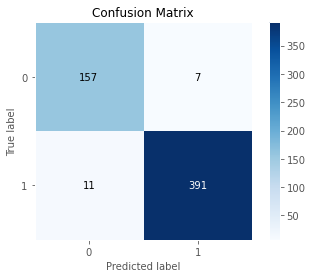

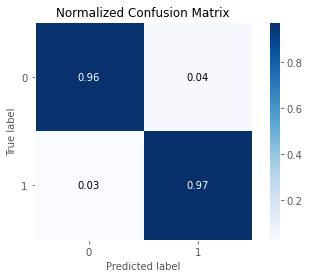

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

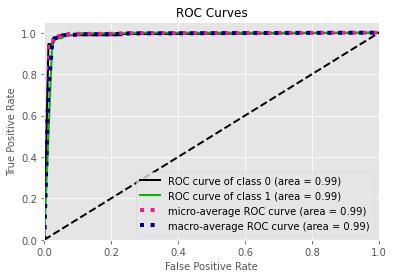

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       164
           1       0.98      0.97      0.98       402

    accuracy                           0.97       566
   macro avg       0.96      0.96      0.96       566
weighted avg       0.97      0.97      0.97       566

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.96      0.97      0.95      0.96      0.93       164
          1       0.98      0.97      0.96      0.98      0.96      0.93       402

avg / total       0.97      0.97      0.96      0.97      0.96      0.93       566

